# Posterior inference on a birth-death model

In [15]:
from collections import defaultdict
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jax import jit
from jax.config import config
from mcmc_diagnostics import estimate_ess
from scipy.stats import gamma, lognorm, norm

from gcdyn import models, mutators, poisson, utils
from gcdyn.mcmc import Parameter, mh_chain

config.update("jax_enable_x64", True)

## Set up truth

In [2]:
# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

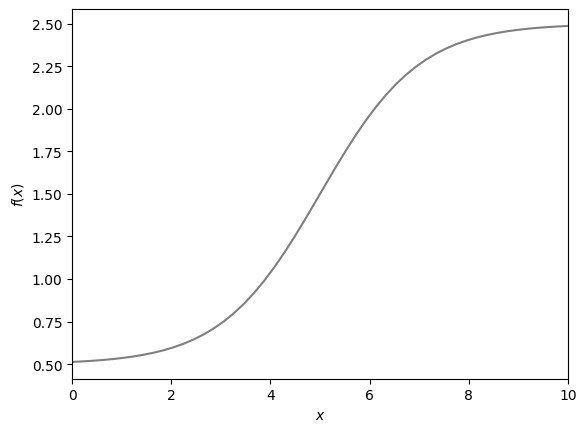

In [3]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

## Sample trees

In [4]:
seed = 10

PRESENT_TIME = 4

trees = utils.sample_trees(n=10, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    if true_parameters["extinct_sampling_probability"] == 1:
        tree._pruned = True
    elif true_parameters["extinct_sampling_probability"] == 0:
        tree.prune()

print(
    "After pruning: average of",
    sum(len(list(tree.traverse())) for tree in trees) / len(trees),
    "nodes per tree, over",
    len(trees),
    "trees.",
)

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 65 times.
Success: average of 262.1 nodes per tree, over 10 trees.
After pruning: average of 120.2 nodes per tree, over 10 trees.


## Configure priors and proposals

In [5]:
parameters = dict(
    xscale=Parameter(
        prior_log_density=gamma(a=2, scale=1).logpdf,
        prior_generator=lambda n: gamma(a=2, scale=1).rvs(n),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=3).logpdf(p),
        proposal_generator=lambda c: lognorm(scale=c, s=3).rvs(1),
    ),
    xshift=Parameter(
        prior_log_density=norm(loc=5, scale=1).logpdf,
        prior_generator=lambda n: norm(loc=5, scale=1).rvs(n),
        proposal_log_density=lambda p, c: norm(loc=c, scale=2).logpdf(p),
        proposal_generator=lambda c: norm(loc=c, scale=2).rvs(1),
    ),
    yscale=Parameter(
        prior_log_density=gamma(a=2, scale=1).logpdf,
        prior_generator=lambda n: gamma(a=2, scale=1).rvs(n),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=1).logpdf(p),
        proposal_generator=lambda c: lognorm(scale=c, s=1).rvs(1),
    ),
    # yshift=Parameter(
    #     prior_log_density=gamma(a=1, scale=1 / 2).logpdf,
    #     prior_generator=lambda n: gamma(a=1, scale=1 / 2).rvs(n),
    #     proposal_log_density=lambda p, c: lognorm(scale=c, s=1).logpdf(p),
    #     proposal_generator=lambda c: lognorm(scale=c, s=1).rvs(1),
    # ),
    # death_rate_value=Parameter(
    #     prior_log_density=gamma(a=3.5, scale=1 / 3).logpdf,
    #     prior_generator=lambda n: gamma(a=3.5, scale=1 / 3).rvs(n),
    #     proposal_log_density=lambda p, c: lognorm(scale=c, s=0.5).logpdf(p),
    #     proposal_generator=lambda c: lognorm(scale=c, s=0.5).rvs(1),
    # ),
)

## Configure likelihood

First we create a jitted likelihood function which fixes the parameters we won't be sampling

In [6]:
log_likelihood_base = jit(
    partial(
        models.stadler_appx_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=true_parameters["extinct_sampling_probability"],
        present_time=PRESENT_TIME,
    )
)

Now we create a non-jitted wrapper around that function, whose arguments match the parameters we want to sample.
This can be modified without recompiling the jitted base function

In [7]:
# def log_likelihood_wrapper(death_rate_value, **birth_params):
#     return log_likelihood_base(
#         birth_response=poisson.SigmoidResponse(
#             **birth_params,
#             yshift=true_parameters["birth_response"].yshift,
#         ),
#         death_response=poisson.ConstantResponse(death_rate_value),
#     )


def log_likelihood_wrapper(**birth_params):
    return log_likelihood_base(
        birth_response=poisson.SigmoidResponse(
            **birth_params,
            yshift=true_parameters["birth_response"].yshift,
        ),
        death_response=true_parameters["death_response"],
    )

## Run MCMC

In [8]:
posterior_samples, stats = mh_chain(
    length=2000,
    parameters=parameters,
    log_likelihood=log_likelihood_wrapper,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Traceplots

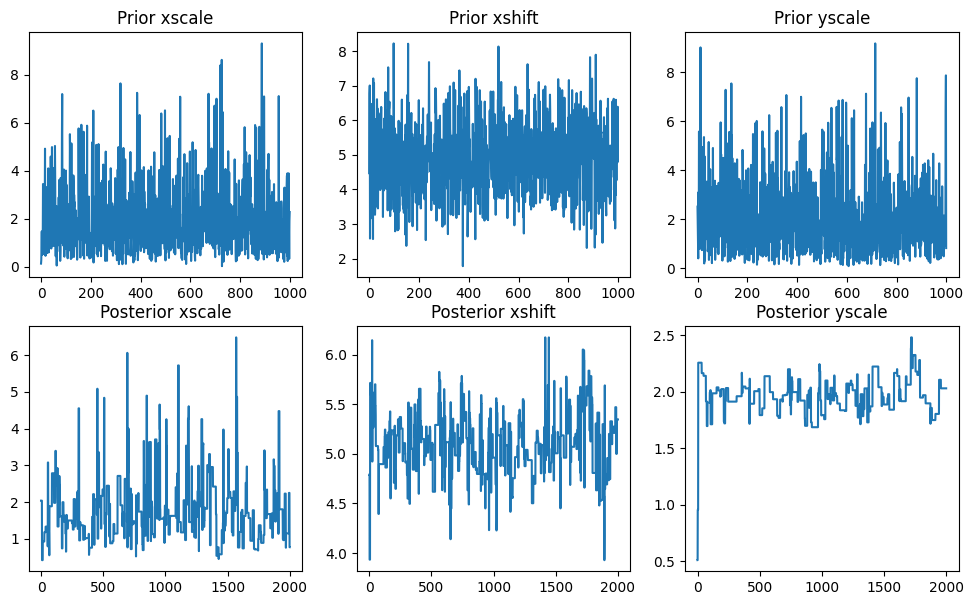

In [9]:
prior_samples = {
    name: param.prior_generator(1000) for name, param in parameters.items()
}

fig, axes = plt.subplots(2, len(posterior_samples))
fig.set_figwidth(12)
fig.set_figheight(7)

for i, param in enumerate(posterior_samples):
    sns.lineplot(prior_samples[param], ax=axes[0, i])
    axes[0, i].set_title(f"Prior {param}")
    sns.lineplot(posterior_samples[param], ax=axes[1, i])
    axes[1, i].set_title(f"Posterior {param}")

plt.show()

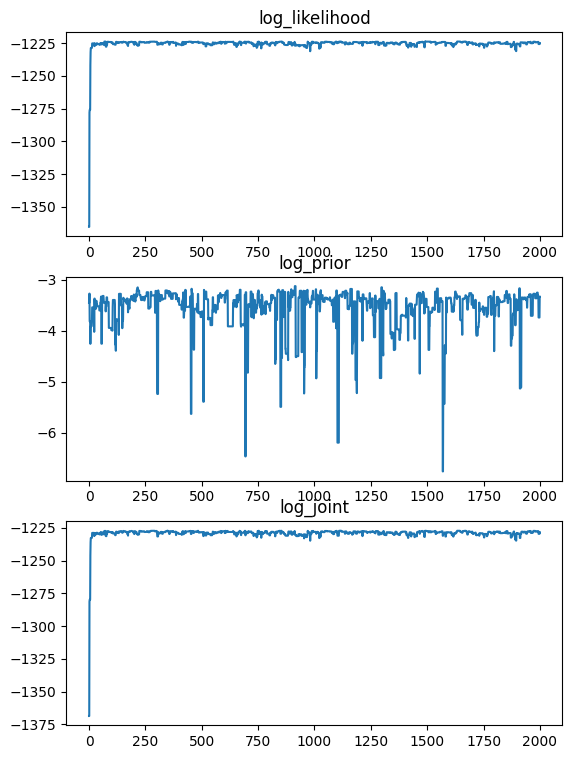

In [10]:
fig, axes = plt.subplots(len(stats))
fig.set_figheight(9)

for ax, stat in zip(axes, stats):
    sns.lineplot(stats[stat], ax=ax)
    ax.set_title(stat)

plt.show()

## Summaries

In [16]:
summary = defaultdict(list)

for param in sorted(posterior_samples.keys()):
    summary["Parameter"].append(param)
    summary["Total samples"].append(len(posterior_samples[param]))
    summary["ESS"].append(estimate_ess(posterior_samples[param]).item())
    summary["Acceptance ratio"].append(
        np.mean(posterior_samples[param][:-1] != posterior_samples[param][1:])
    )
    summary["Prior mean"].append(prior_samples[param].mean())
    summary["Posterior mean"].append(posterior_samples[param].mean())

pd.DataFrame(summary).round(2).set_index("Parameter")

,Total samples,ESS,Acceptance ratio,Prior mean,Posterior mean
Parameter,,,,,
xscale,2001,192.23,0.14,1.97,1.76
xshift,2001,112.30,0.16,4.95,5.11
yscale,2001,63.34,0.07,2.01,1.96


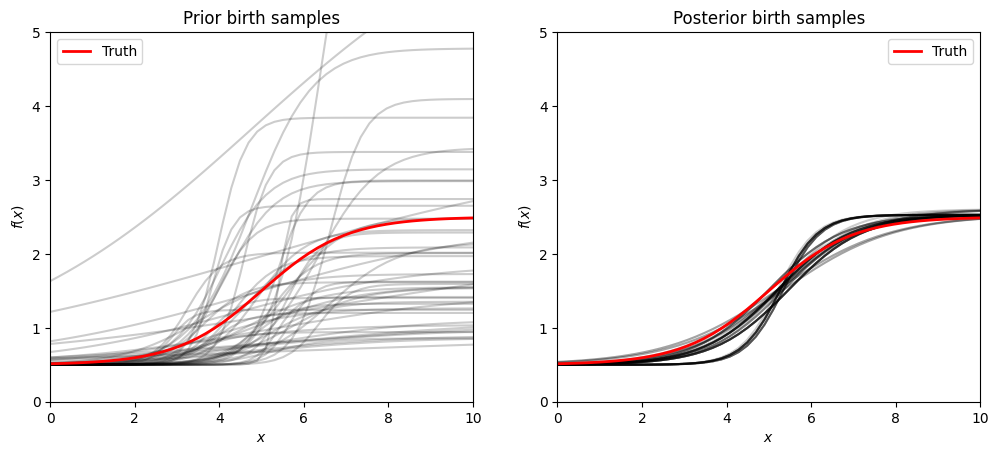

In [12]:
x_array = np.linspace(0, 10)

fig, axes = plt.subplots(1, 2)

for samples, ax in zip((prior_samples, posterior_samples), axes):
    birth_responses = []

    for i in range(len(samples["xscale"]) - 50, len(samples["xscale"])):
        response = poisson.SigmoidResponse(
            xscale=samples["xscale"][i].item(),
            xshift=samples["xshift"][i].item(),
            yscale=samples["yscale"][i].item(),
            yshift=true_parameters["birth_response"].yshift,
            # yshift=samples["yshift"][i].item(),
        )

        birth_responses.append(response)

    for response in birth_responses:
        ax.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)

    ax.plot(
        x_array,
        true_parameters["birth_response"].λ_phenotype(x_array),
        label="Truth",
        linewidth=2,
        color="red",
    )

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.legend()

axes[0].set_title("Prior birth samples")
axes[1].set_title("Posterior birth samples")
fig.set_figwidth(12)
plt.show()

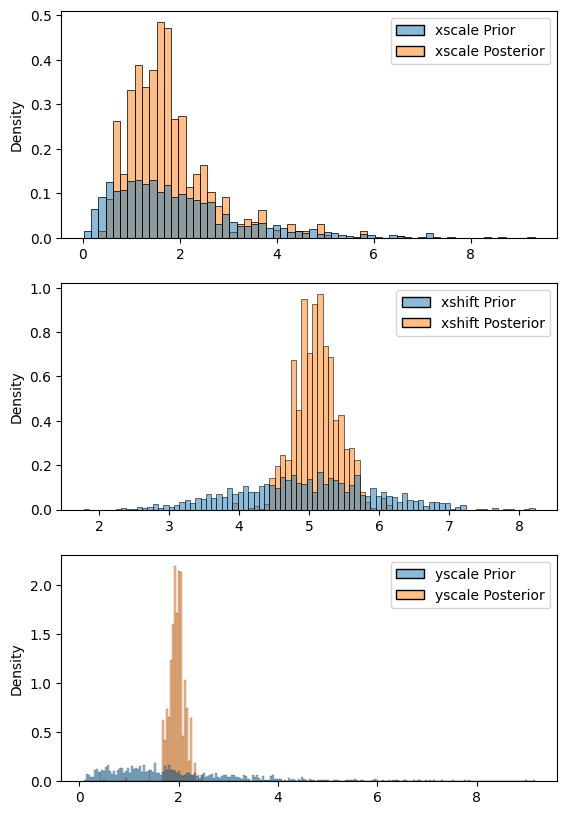

In [13]:
fig, axes = plt.subplots(len(posterior_samples), 1)
fig.set_figheight(10)

for ax, param in zip(axes, posterior_samples):
    s = {
        f"{param} Prior": prior_samples[param],
        f"{param} Posterior": posterior_samples[param],
    }

    sns.histplot(s, ax=ax, stat="density")